In [184]:
# All libraries to be used.

import torchvision
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
import seaborn as sns

from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torchmetrics import F1Score, ConfusionMatrix

Part 1 : Creating the custom Dataset class.

In [185]:
class Dataset():
    def __init__(self, classes, n_train, n_test, train_val_ratio):
        random.seed(42)

        transform_params = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        # Train Set Loading
        loaded_data = torchvision.datasets.CIFAR10(root='./data/train', train=True, download=True, transform=transform_params)

        # Selecting only the classes in "classes" var.
        class_filt_data = [(transform_params(image), label) for image, label in zip(loaded_data.data, loaded_data.targets) if label in classes]

        random.shuffle(class_filt_data)
        num_filt_data = class_filt_data[:n_train] # Selecting n_train samples at random.
        filtered_images, filtered_labels = zip(*num_filt_data)

        train, val, train_labels, val_labels = train_test_split(
            filtered_images, filtered_labels,
            test_size = 1 - train_val_ratio,
            stratify = filtered_labels,  # Stratified Sampling
            random_state = 42
        )

        # Assigning the data to a Tensor Dataset for loading it later.
        val = torch.stack([torch.Tensor(img) for img in val])
        val_labels = torch.tensor(val_labels)
        self.val_data = TensorDataset(val, val_labels)

        train = torch.stack([torch.Tensor(img) for img in train])
        train_labels = torch.tensor(train_labels)
        self.train_data = TensorDataset(train, train_labels)

        # ----------------------------------------------------------------------------------
        # Test Set Loading

        loaded_data = torchvision.datasets.CIFAR10(root='./data/test', train=False, download=True, transform=transform_params)

        class_filtered_data = {class_no: [] for class_no in classes} # To store data per class.
        for img, label in zip(loaded_data.data, loaded_data.targets):
            if label in classes:
                class_filtered_data[label].append(transform_params(img))

        samples_per_class = n_test // len(classes)

        # Randomly selecting 'samples_per_class' images from each label.
        filtered_images = []
        for class_no in class_filtered_data:
            class_data = class_filtered_data[class_no]
            random.shuffle(class_data)
            filtered_images.extend(class_data[:samples_per_class])

        # Making the updated labels.
        filtered_labels = []
        for class_id in class_filtered_data:
            filtered_labels.extend([class_id] * samples_per_class)

        test = torch.stack([torch.Tensor(img) for img in filtered_images])  # Stacking them back together.
        test_labels = torch.tensor(filtered_labels)  # Converting to a tensor.
        self.test_data = TensorDataset(test, test_labels)


    def load_train(self):
        train_loader = DataLoader(self.train_data, batch_size=32, shuffle=False)

        img_arr = []
        label_arr = []
        for images, labels in train_loader:
            img_arr.append(images)
            label_arr.append(labels)

        x_train = torch.cat(img_arr, dim=0)
        y_train = torch.cat(label_arr, dim=0)

        return x_train, y_train

    def load_val(self):
        val_loader = DataLoader(self.val_data, batch_size=32, shuffle=False)

        img_arr = []
        label_arr = []
        for images, labels in val_loader:
            img_arr.append(images)
            label_arr.append(labels)

        x_val = torch.cat(img_arr, dim=0)
        y_val = torch.cat(label_arr, dim=0)

        return x_val, y_val

    def load_test(self):
        test_loader = DataLoader(self.test_data, batch_size=32, shuffle=False)

        img_arr = []
        label_arr = []
        for images, labels in test_loader:
            img_arr.append(images)
            label_arr.append(labels)

        x_test = torch.cat(img_arr, dim=0)
        y_test = torch.cat(label_arr, dim=0)

        return x_test, y_test

In [186]:
dataset_loader = Dataset(classes = [0,1,2], n_train = 15000, n_test = 3000, train_val_ratio = 0.8)

x_train, y_train = dataset_loader.load_train()
x_val, y_val = dataset_loader.load_val()
x_test, y_test = dataset_loader.load_test()

Files already downloaded and verified
Files already downloaded and verified


Part 2 - Visualization

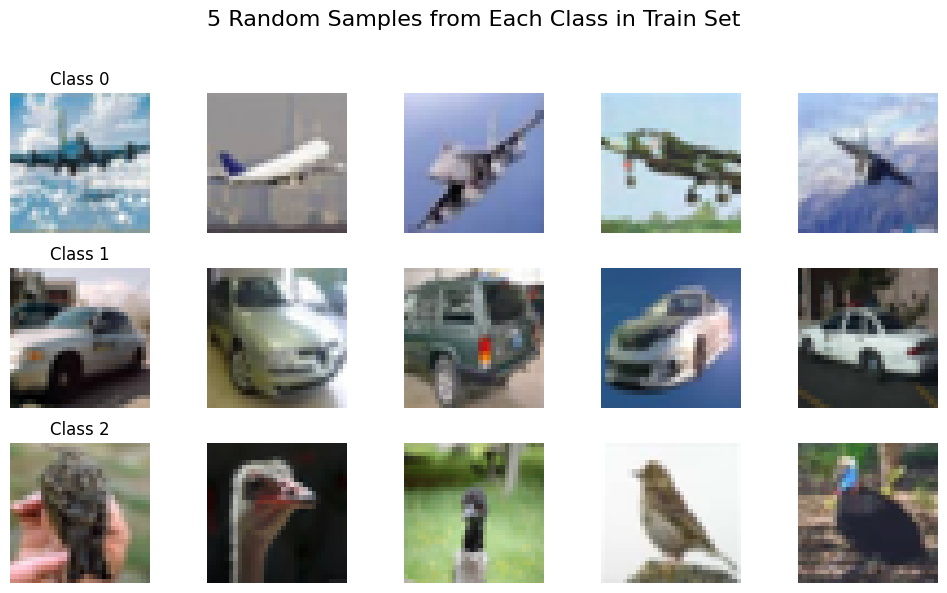

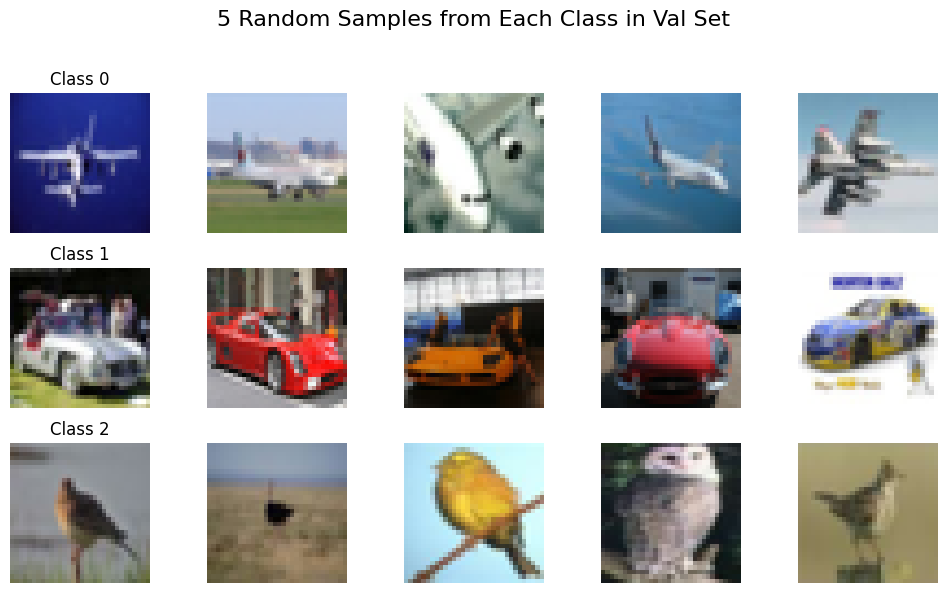

In [187]:
import torch
import random
import matplotlib.pyplot as plt

list_samples_train = {i: [] for i in range(3)} # Storing samples of each class in train in a dictionary.
list_samples_val = {i: [] for i in range(3)} # Val

for img, label in zip(x_train, y_train):
    list_samples_train[label.item()].append(img) # Label.item() since it's a tensor, so we need to extract the scalar value.

for img, label in zip(x_val, y_val):
    list_samples_val[label.item()].append(img)

# Randomly sampling from the above samples.
random_samples_train = {class_no: random.sample(samples, 5) for class_no, samples in list_samples_train.items()}
random_samples_val = {class_no: random.sample(samples, 5) for class_no, samples in list_samples_val.items()}

# Train Plot
fig, axs = plt.subplots(3, 5, figsize=(10, 6))
fig.suptitle(f"5 Random Samples from Each Class in Train Set", fontsize=16)

for class_no, images in random_samples_train.items():
    for i, img in enumerate(images):
        img = img * 0.5 + 0.5  # Cancelling the effects of the normalizing done in pre-processing.
        img = img.permute(1,2,0) # Converting from (Color Channels, Height, Width) to (Height, Width, Color Channels)
        axs[class_no, i].imshow(img)
        axs[class_no, i].axis('off')
        if i == 0:
            axs[class_no, i].set_title(f"Class {class_no}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plotting Val Set
fig, axs = plt.subplots(3, 5, figsize=(10, 6))
fig.suptitle(f"5 Random Samples from Each Class in Val Set", fontsize=16)

for class_no, images in random_samples_val.items():
    for i, img in enumerate(images):
        img = img * 0.5 + 0.5  # Cancelling the effects of the normalizing done in pre-processing.
        img = img.permute(1, 2, 0)  # Converting from (Color Channels, Height, Width) to (Height, Width, Color Channels)
        axs[class_no, i].imshow(img)
        axs[class_no, i].axis('off')
        if i == 0:
            axs[class_no, i].set_title(f"Class {class_no}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Part 3 - Making the Model

In [188]:
# Took help from GFG - https://www.geeksforgeeks.org/implementation-of-a-cnn-based-image-classifier-using-pytorch/ to understand
# how to make a CNN model.

class CNN(torch.nn.Module): 
	def __init__(self): 
		super().__init__() 

		self.model = torch.nn.Sequential( 
			torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding = 1, stride = 1), # (3,32,32) -> (16,30,30)
			torch.nn.ReLU(),
			torch.nn.MaxPool2d(kernel_size = 3, stride = 2), # (16,30,30) -> (16,14,14)
			
			torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 0, stride = 1), # (16,14,14) -> (32,12,12)
			torch.nn.ReLU(),
			torch.nn.MaxPool2d(kernel_size = 3, stride = 3), # (32,12,12) -> (32,4,4)
			torch.nn.Flatten(),
			
			torch.nn.Linear(512, 16), # MLP where 512 comes from 32 * 4 * 4
			torch.nn.ReLU(),
			
            torch.nn.Linear(16, 3)
		)
	
	def forward(self, x):
		return self.model(x)

Part 4 -> Training The Model

In [189]:
# Took help from GFG - https://www.geeksforgeeks.org/implementation-of-a-cnn-based-image-classifier-using-pytorch/ to understand
# how to make a CNN model.

if torch.cuda.is_available():
	device = 'cuda'
else:
	device = 'cpu'
	
model = CNN().to(device) # Assigning it to either the GPU or CPU depending on availability.

# Setting the Hyperparameters
n_epochs = 15
learning_rate = 0.001
loss_fn = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

# Training
train_loss_arr = [] 
val_loss_arr = []
train_accuracy_arr = []
val_accuracy_arr = []

for epoch in range(n_epochs):
	model.train() # Setting the model to train mode.
	for img, label in zip(x_train, y_train):
		img = img.to(device)
		img = img.unsqueeze(0)

		label = label.to(device) 
		label = label.unsqueeze(0)

		output = model(img) # Obtaining output.
		loss = loss_fn(output, label) # Calculating Loss.

		optimizer.zero_grad() # Clearing out old gradients.
		loss.backward() # Computes the new gradient.
		optimizer.step() # Updates the model.

	model.eval() # Setting the model to eval mode.

	train_loss = 0
	val_loss = 0

	n_corr_train = 0
	n_corr_val = 0

	with torch.no_grad(): # Disabling gradient updation/finding out to reduce computation.
		idx = 0
		for img, label in zip(x_train, y_train):
			img = img.to(device)
			img = img.unsqueeze(0)

			label = label.to(device)
			label = label.unsqueeze(0)
			
			output = model(img) # Obtaining output.

			loss = loss_fn(output, label) # Calculating Loss.
			train_loss += loss

			tmp, predicted_class = torch.max(output, 1) # Finding the predicted class.
			if predicted_class == y_train[idx].item():
				n_corr_train += 1
				
			idx += 1

		idx = 0
		for img, label in zip(x_val, y_val):
			img = img.to(device)
			img = img.unsqueeze(0)

			label = label.to(device)
			label = label.unsqueeze(0)
			
			output = model(img) # Obtaining output.

			loss = loss_fn(output, label) # Calculating Loss.
			val_loss += loss

			tmp, predicted_class = torch.max(output, 1) # Finding the predicted class.
			if predicted_class == y_val[idx].item():
				n_corr_val += 1
				
			idx += 1
	
	train_loss_arr.append(train_loss / len(y_train))
	val_loss_arr.append(val_loss / len(y_val)) 
	train_accuracy_arr.append(round((n_corr_train / len(y_train)) * 100, 2))
	val_accuracy_arr.append(round((n_corr_val / len(y_val)) * 100, 2))

	print(f"At Epoch {epoch + 1}, training loss = {train_loss_arr[-1]}, val loss = {val_loss_arr[-1]}.") 
	print(f"At Epoch {epoch + 1}, training accuracy = {train_accuracy_arr[-1]}%, val accuracy = {val_accuracy_arr[-1]}%.\n") 

At Epoch 1, training loss = 0.4237169623374939, val loss = 0.4597654640674591.
At Epoch 1, training accuracy = 83.43%, val accuracy = 81.8%.

At Epoch 2, training loss = 0.3324527442455292, val loss = 0.3932926058769226.
At Epoch 2, training accuracy = 87.41%, val accuracy = 84.8%.

At Epoch 3, training loss = 0.31553834676742554, val loss = 0.4031313955783844.
At Epoch 3, training accuracy = 88.38%, val accuracy = 85.33%.

At Epoch 4, training loss = 0.28336822986602783, val loss = 0.3762299418449402.
At Epoch 4, training accuracy = 89.26%, val accuracy = 85.67%.

At Epoch 5, training loss = 0.2687137722969055, val loss = 0.3872677683830261.
At Epoch 5, training accuracy = 89.81%, val accuracy = 86.93%.

At Epoch 6, training loss = 0.2616143226623535, val loss = 0.4081485867500305.
At Epoch 6, training accuracy = 90.22%, val accuracy = 86.33%.

At Epoch 7, training loss = 0.24890264868736267, val loss = 0.41519156098365784.
At Epoch 7, training accuracy = 90.48%, val accuracy = 86.3%.

Saving the Model

In [190]:
torch.save(model.state_dict(), "model_CNN.pth")

In [191]:
model = CNN().to('cuda')
model.load_state_dict(torch.load("model_CNN.pth"))

<All keys matched successfully>

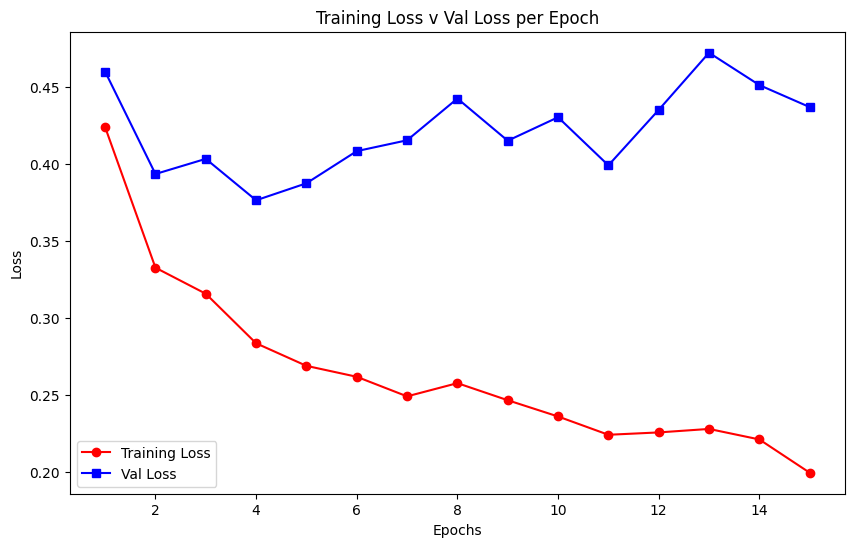

In [192]:
epochs = [i for i in range(1, 16)]

train_arr = [loss.item() for loss in train_loss_arr]
val_arr = [loss.item() for loss in val_loss_arr]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_arr, label="Training Loss", color='r', marker='o')
plt.plot(epochs, val_arr, label="Val Loss", color='b', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss v Val Loss per Epoch')
plt.legend()
plt.show()

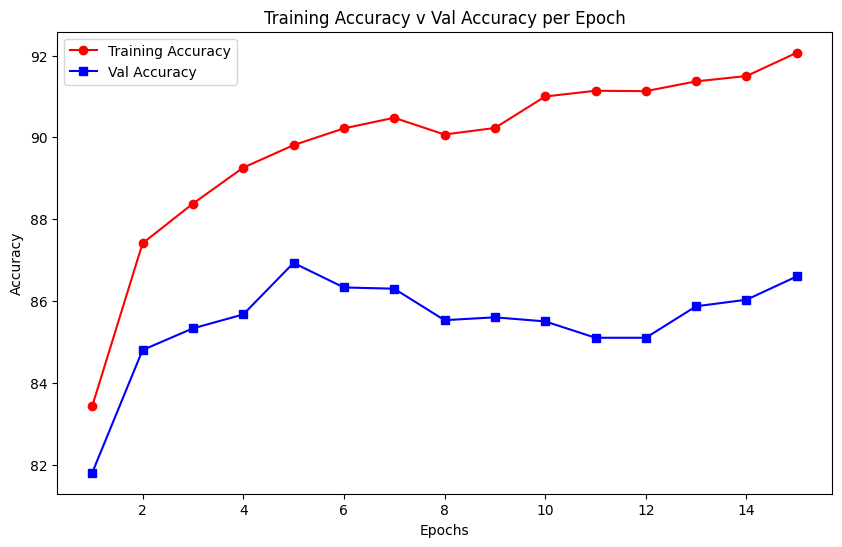

In [193]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy_arr, label="Training Accuracy", color='r', marker='o')
plt.plot(epochs, val_accuracy_arr, label="Val Accuracy", color='b', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy v Val Accuracy per Epoch')
plt.legend()
plt.show()

Observations:-

1) The val loss indicates that there is overfitting, since from epoch 8 onwards, there is an increase in val loss, which is a good indicator of overfitting.
2) The accuracies for train are increasing steadily which is good, while the val accuracy does stop increasing after epoch 5 and oscillates a bit, with the model perhaps not generalizing as well as the training loss indicates.
3) So, overall, one could say that the model should have been stopped a bit earlier, since it's overfitting but it's still just about fine.

Part 5 -> Results

Test Accuracy -> 85.97%
Test F1 Score -> 0.8590298891067505



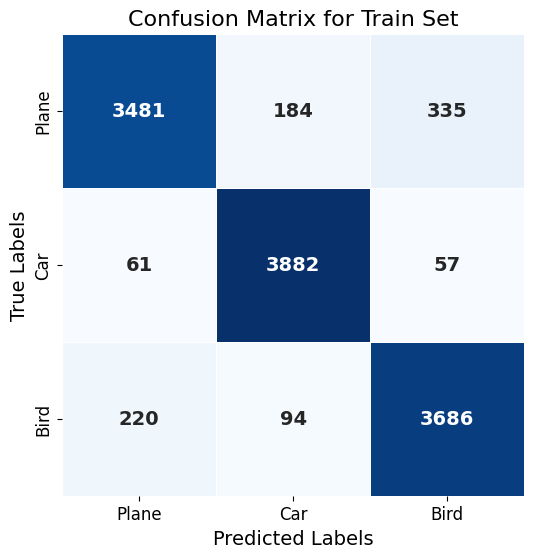

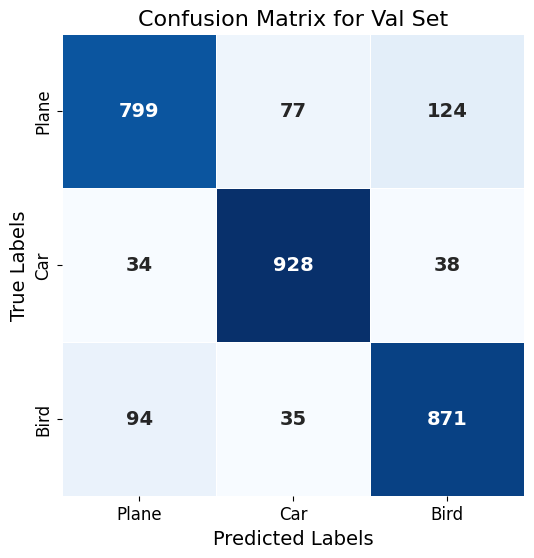

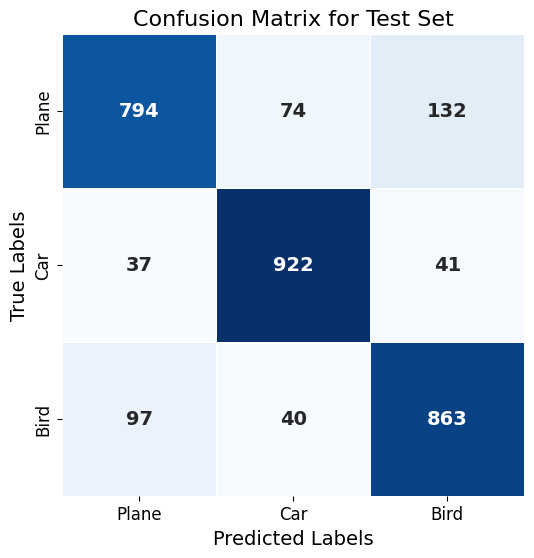

In [194]:
model.eval() # Setting the model to eval mode.

n_corr_test = 0
y_pred_test = []
y_pred_train = []
y_pred_val = []

with torch.no_grad(): # Disabling gradient updation/finding out to reduce computation.
    idx = 0
    for img, label in zip(x_test, y_test):
        img = img.to(device)
        img = img.unsqueeze(0)

        label = label.to(device)
        label = label.unsqueeze(0)
        
        output = model(img) # Obtaining output.

        tmp, predicted_class = torch.max(output, 1) # Finding the predicted class.
        if predicted_class == y_test[idx].item():
            n_corr_test += 1
        y_pred_test.append(predicted_class)
            
        idx += 1

    idx = 0
    for img, label in zip(x_train, y_train):
        img = img.to(device)
        img = img.unsqueeze(0)

        label = label.to(device)
        label = label.unsqueeze(0)
        
        output = model(img) # Obtaining output.
        tmp, predicted_class = torch.max(output, 1) # Finding the predicted class.
        y_pred_train.append(predicted_class)
            
        idx += 1

    idx = 0
    for img, label in zip(x_val, y_val):
        img = img.to(device)
        img = img.unsqueeze(0)

        label = label.to(device)
        label = label.unsqueeze(0)
        
        output = model(img) # Obtaining output.
        tmp, predicted_class = torch.max(output, 1) # Finding the predicted class.
        y_pred_val.append(predicted_class)
            
        idx += 1

y_pred_test_tensor = torch.tensor(y_pred_test)
y_pred_train_tensor = torch.tensor(y_pred_train)
y_pred_val_tensor = torch.tensor(y_pred_val)

test_accuracy = round((n_corr_test / len(y_test)) * 100, 2)

f1 = F1Score(task = 'multiclass', num_classes = 3, average = 'macro')
f1_score = f1(y_pred_test_tensor, y_test)

print(f"Test Accuracy -> {test_accuracy}%")
print(f"Test F1 Score -> {f1_score.item()}\n")


# Confusion Matrix for Train Set
confusion_model = ConfusionMatrix(task = 'multiclass', num_classes = 3)
confusion_matrix = confusion_model(y_pred_train_tensor, y_train)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            annot_kws={"size": 14, "weight": "bold"}, linewidths=0.5)

plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix for Train Set", fontsize=16)
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Plane', 'Car', 'Bird'], fontsize=12)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Plane', 'Car', 'Bird'], fontsize=12)

plt.show()


# Confusion Matrix for Val Set
confusion_model = ConfusionMatrix(task = 'multiclass', num_classes = 3)
confusion_matrix = confusion_model(y_pred_val_tensor, y_val)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            annot_kws={"size": 14, "weight": "bold"}, linewidths=0.5)

plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix for Val Set", fontsize=16)
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Plane', 'Car', 'Bird'], fontsize=12)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Plane', 'Car', 'Bird'], fontsize=12)

plt.show()


# Confusion Matrix for Test Set
confusion_model = ConfusionMatrix(task = 'multiclass', num_classes = 3)
confusion_matrix = confusion_model(y_pred_test_tensor, y_test)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            annot_kws={"size": 14, "weight": "bold"}, linewidths=0.5)

plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix for Test Set", fontsize=16)
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Plane', 'Car', 'Bird'], fontsize=12)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Plane', 'Car', 'Bird'], fontsize=12)

plt.show()

Part 6 -> MLP Model

In [196]:
class MLP(torch.nn.Module): 
	def __init__(self): 
		super().__init__() 

		self.model = torch.nn.Sequential( 
			torch.nn.Flatten(), # Flattens from (3,32,32) to (3*32*32)
			
            torch.nn.Linear(3*32*32, 64), # MLP where first layer is the newly formed flattened layer.
			torch.nn.ReLU(),
			
            torch.nn.Linear(64, 3) # Output is 3 since there are 3 classes.
		)
	
	def forward(self, x):
		return self.model(x)

Training the model.

In [197]:
if torch.cuda.is_available():
	device = 'cuda'
else:
	device = 'cpu'
	
model = MLP().to(device) # Assigning it to either the GPU or CPU depending on availability.

# Setting the Hyperparameters
n_epochs = 15
learning_rate = 0.001
loss_fn = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

# Training
train_loss_arr_mlp = [] 
val_loss_arr_mlp = []
train_accuracy_arr_mlp = []
val_accuracy_arr_mlp = []

for epoch in range(n_epochs):
	model.train() # Setting the model to train mode.
	for img, label in zip(x_train, y_train):
		img = img.to(device)
		img = img.unsqueeze(0)

		label = label.to(device) 
		label = label.unsqueeze(0)

		output = model(img) # Obtaining output.
		loss = loss_fn(output, label) # Calculating Loss.

		optimizer.zero_grad() # Clearing out old gradients.
		loss.backward() # Computes the new gradient.
		optimizer.step() # Updates the model.

	model.eval() # Setting the model to eval mode.

	train_loss = 0
	val_loss = 0

	n_corr_train = 0
	n_corr_val = 0

	with torch.no_grad(): # Disabling gradient updation/finding out to reduce computation.
		idx = 0
		for img, label in zip(x_train, y_train):
			img = img.to(device)
			img = img.unsqueeze(0)

			label = label.to(device)
			label = label.unsqueeze(0)
			
			output = model(img) # Obtaining output.

			loss = loss_fn(output, label) # Calculating Loss.
			train_loss += loss

			tmp, predicted_class = torch.max(output, 1) # Finding the predicted class.
			if predicted_class == y_train[idx].item():
				n_corr_train += 1
				
			idx += 1

		idx = 0
		for img, label in zip(x_val, y_val):
			img = img.to(device)
			img = img.unsqueeze(0)

			label = label.to(device)
			label = label.unsqueeze(0)
			
			output = model(img) # Obtaining output.

			loss = loss_fn(output, label) # Calculating Loss.
			val_loss += loss

			tmp, predicted_class = torch.max(output, 1) # Finding the predicted class.
			if predicted_class == y_val[idx].item():
				n_corr_val += 1
				
			idx += 1
	
	train_loss_arr_mlp.append(train_loss / len(y_train))
	val_loss_arr_mlp.append(val_loss / len(y_val)) 
	train_accuracy_arr_mlp.append(round((n_corr_train / len(y_train)) * 100, 2))
	val_accuracy_arr_mlp.append(round((n_corr_val / len(y_val)) * 100, 2))

	print(f"At Epoch {epoch + 1}, training loss = {train_loss_arr_mlp[-1]}, val loss = {val_loss_arr_mlp[-1]}.") 
	print(f"At Epoch {epoch + 1}, training accuracy = {train_accuracy_arr_mlp[-1]}%, val accuracy = {val_accuracy_arr_mlp[-1]}%.\n") 

At Epoch 1, training loss = 0.6678105592727661, val loss = 0.7364482879638672.
At Epoch 1, training accuracy = 74.18%, val accuracy = 72.43%.

At Epoch 2, training loss = 0.6286714673042297, val loss = 0.7451744675636292.
At Epoch 2, training accuracy = 76.5%, val accuracy = 73.2%.

At Epoch 3, training loss = 0.5939379930496216, val loss = 0.7552462220191956.
At Epoch 3, training accuracy = 77.6%, val accuracy = 73.1%.

At Epoch 4, training loss = 0.588076651096344, val loss = 0.7956382036209106.
At Epoch 4, training accuracy = 77.98%, val accuracy = 72.47%.

At Epoch 5, training loss = 0.6499347686767578, val loss = 0.8938325643539429.
At Epoch 5, training accuracy = 78.01%, val accuracy = 72.77%.

At Epoch 6, training loss = 0.6365892887115479, val loss = 0.9020106792449951.
At Epoch 6, training accuracy = 78.29%, val accuracy = 72.03%.

At Epoch 7, training loss = 0.6162922978401184, val loss = 0.9532926082611084.
At Epoch 7, training accuracy = 80.0%, val accuracy = 72.03%.

At Ep

Saving the model to a .pth file.

In [198]:
torch.save(model.state_dict(), "model_MLP.pth")

In [200]:
model = MLP().to('cuda')
model.load_state_dict(torch.load("model_MLP.pth"))

<All keys matched successfully>

Plotting the loss/accuracy graphs.

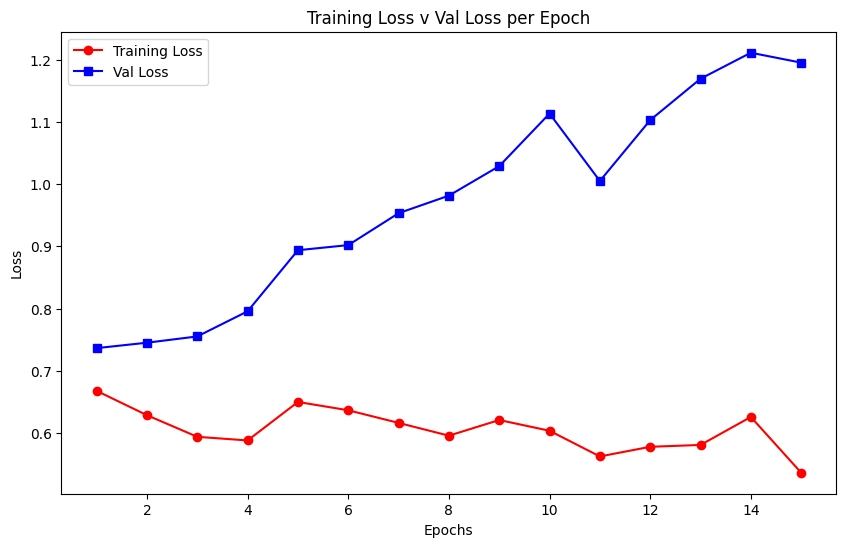

In [201]:
epochs = [i for i in range(1, 16)]

train_arr_mlp = [loss.item() for loss in train_loss_arr_mlp]
val_arr_mlp = [loss.item() for loss in val_loss_arr_mlp]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_arr_mlp, label="Training Loss", color='r', marker='o')
plt.plot(epochs, val_arr_mlp, label="Val Loss", color='b', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss v Val Loss per Epoch')
plt.legend()
plt.show()

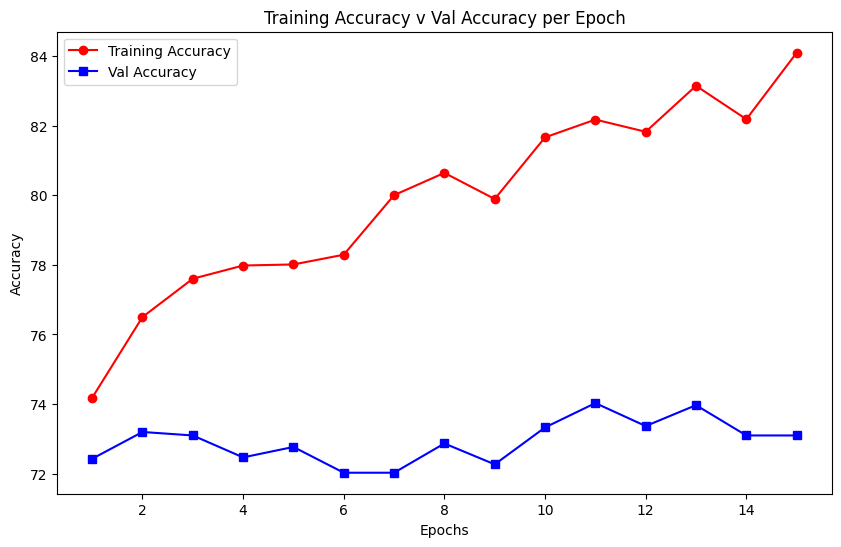

In [202]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy_arr_mlp, label="Training Accuracy", color='r', marker='o')
plt.plot(epochs, val_accuracy_arr_mlp, label="Val Accuracy", color='b', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy v Val Accuracy per Epoch')
plt.legend()
plt.show()

Observations:-

1) Overfitting immensely, as observed by the rapidly increasing loss, and the accuracy that is oscillating.
2) Training Loss is improving over time, so doesn't generalize well.

Part 7 - Infer and Compare

Test Accuracy -> 73.93%
Test F1 Score -> 0.7409377694129944



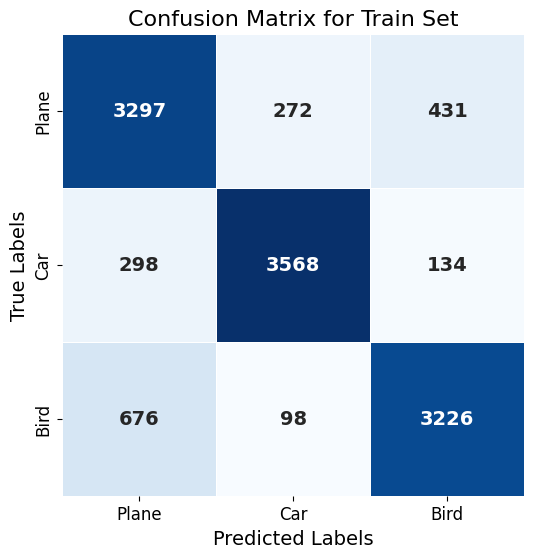

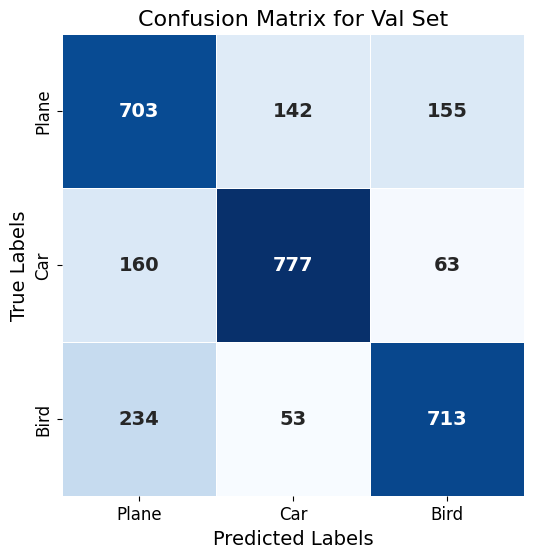

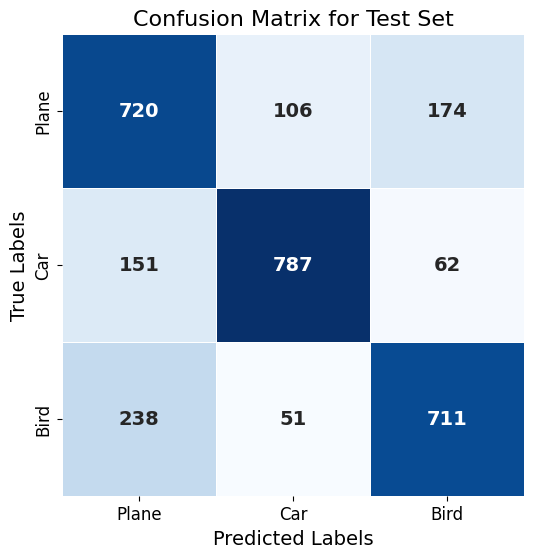

In [203]:
model.eval() # Setting the model to eval mode.

n_corr_test = 0
y_pred_test = []
y_pred_train = []
y_pred_val = []

with torch.no_grad(): # Disabling gradient updation/finding out to reduce computation.
    idx = 0
    for img, label in zip(x_test, y_test):
        img = img.to(device)
        img = img.unsqueeze(0)

        label = label.to(device)
        label = label.unsqueeze(0)
        
        output = model(img) # Obtaining output.

        tmp, predicted_class = torch.max(output, 1) # Finding the predicted class.
        if predicted_class == y_test[idx].item():
            n_corr_test += 1
        y_pred_test.append(predicted_class)
            
        idx += 1

    idx = 0
    for img, label in zip(x_train, y_train):
        img = img.to(device)
        img = img.unsqueeze(0)

        label = label.to(device)
        label = label.unsqueeze(0)
        
        output = model(img) # Obtaining output.
        tmp, predicted_class = torch.max(output, 1) # Finding the predicted class.
        y_pred_train.append(predicted_class)
            
        idx += 1

    idx = 0
    for img, label in zip(x_val, y_val):
        img = img.to(device)
        img = img.unsqueeze(0)

        label = label.to(device)
        label = label.unsqueeze(0)
        
        output = model(img) # Obtaining output.
        tmp, predicted_class = torch.max(output, 1) # Finding the predicted class.
        y_pred_val.append(predicted_class)
            
        idx += 1

y_pred_test_tensor = torch.tensor(y_pred_test)
y_pred_train_tensor = torch.tensor(y_pred_train)
y_pred_val_tensor = torch.tensor(y_pred_val)

test_accuracy = round((n_corr_test / len(y_test)) * 100, 2)

f1 = F1Score(task = 'multiclass', num_classes = 3, average = 'macro')
f1_score = f1(y_pred_test_tensor, y_test)

print(f"Test Accuracy -> {test_accuracy}%")
print(f"Test F1 Score -> {f1_score.item()}\n")


# Confusion Matrix for Train Set
confusion_model = ConfusionMatrix(task = 'multiclass', num_classes = 3)
confusion_matrix = confusion_model(y_pred_train_tensor, y_train)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            annot_kws={"size": 14, "weight": "bold"}, linewidths=0.5)

plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix for Train Set", fontsize=16)
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Plane', 'Car', 'Bird'], fontsize=12)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Plane', 'Car', 'Bird'], fontsize=12)

plt.show()


# Confusion Matrix for Val Set
confusion_model = ConfusionMatrix(task = 'multiclass', num_classes = 3)
confusion_matrix = confusion_model(y_pred_val_tensor, y_val)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            annot_kws={"size": 14, "weight": "bold"}, linewidths=0.5)

plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix for Val Set", fontsize=16)
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Plane', 'Car', 'Bird'], fontsize=12)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Plane', 'Car', 'Bird'], fontsize=12)

plt.show()


# Confusion Matrix for Test Set
confusion_model = ConfusionMatrix(task = 'multiclass', num_classes = 3)
confusion_matrix = confusion_model(y_pred_test_tensor, y_test)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            annot_kws={"size": 14, "weight": "bold"}, linewidths=0.5)

plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix for Test Set", fontsize=16)
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Plane', 'Car', 'Bird'], fontsize=12)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Plane', 'Car', 'Bird'], fontsize=12)

plt.show()

Final Comparisons:-

1) Clearly, by looking at both accuracy and macro F1 score on the test set, CNN does a significantly better job. There is a difference in 12% in the accuracy and 0.12 in the F1 score. Clearly these 2 indicate a large difference in performance.

2) Both models do mistake birds with planes and vice versa more so than any other pair. Perhaps, this could be due to the relative similarities in the shape of the 2, which leads to this misclassification. MLP suffers much more in this regard, as one can see from the graph.

3) Predicting cars is a strong suit for both models, clearly this is a follow-up effect of part 2.
4) CNNs overfit a bit less than MLPs though by looking at the loss graphs for both, they both do overfit.
5) In MLPs, the model doesn't train as quickly as CNNs, this can also be analyzed by looking at the loss curves.
6) Clearly, CNNs do a good job at image classification, since both F1 Score and Accuracy are high.